In [59]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

import tensorflow

from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, AlphaDropout
from keras.optimizers import Adam, RMSprop, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard as TensorBoardCallback

# Fashion Classification

<img src="https://raw.githubusercontent.com/roma-glushko/zelando-fashion-mnist/master/doc/fashion-mnist.png" width="600px" />

In [10]:
RANDOM_SEED = 20210116

np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [11]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

# Dataset Overview

In [12]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train, y_train = train_df.drop(['label'], axis=1), train_df['label']
X_test, y_test = test_df.drop(['label'], axis=1), test_df['label']

<AxesSubplot:xlabel='label', ylabel='Count'>

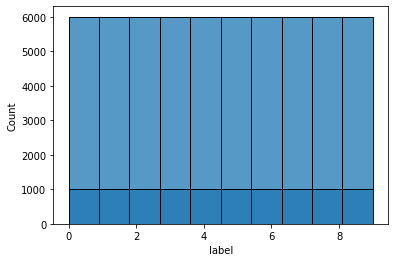

In [14]:
sns.histplot(data=y_train, bins=10)
sns.histplot(data=y_test, bins=10)

In [15]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [16]:
val_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, val_idx in val_splitter.split(X_train, y_train):
    X_train_val, y_train_val = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

In [129]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.001, random_state=RANDOM_SEED)

for _, val_idx in splitter.split(X_train, y_train):
    X_train_overfit, y_train_overfit = X_train.iloc[val_idx], y_train.iloc[val_idx]

In [17]:
label_names = [
    'T-shirt/Top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

label_num = len(label_names)

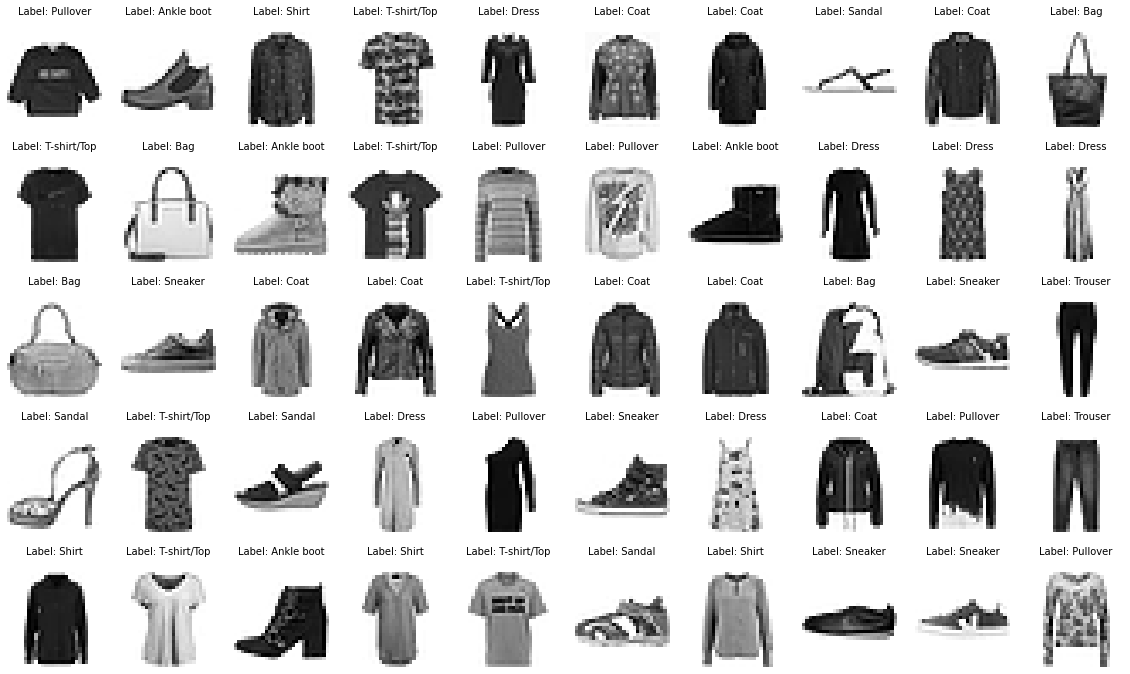

In [18]:
plt.figure(figsize=(20, 12))

for index, (image, label_idx) in enumerate(zip(X_train[0:50], y_train[0:50])):
    label = label_names[label_idx]

    ax = plt.subplot(5, 10, index + 1)
    ax.axis('off')

    plt.imshow(np.reshape(X_train.values[index], (28, 28)), cmap='binary')

    plt.title('Label: %s\n' % label, fontsize=10);

# Classification

In [19]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='rocket_r', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [20]:
def get_log_dir():
    training_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(os.curdir, 'logs', training_id)

In [142]:
input_layer = Input((784), name='input')

#x = Dense(300, activation='relu')(input_layer)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#x = Dense(100, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#x = Dense(50, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

x = Dense(300, activation='selu', kernel_initializer='lecun_normal', name='dense_1')(input_layer)
x = AlphaDropout(0.2, name='alpha_dropout_1')(x)

x = Dense(100, activation='selu', kernel_initializer='lecun_normal', name='dense_2')(x)
x = AlphaDropout(0.2, name='alpha_dropout_2')(x)

x = Dense(50, activation='selu', kernel_initializer='lecun_normal', name='dense_3')(x)
x = AlphaDropout(0.2, name='alpha_dropout_3')(x)

output_layer = Dense(label_num, activation = 'softmax', name='dense_output')(x)

model = Model(input_layer, output_layer)

model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 50)                0  

In [143]:
optimizer = Nadam(lr=0.001)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [144]:
early_stopping_callback = EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('checkpoints/fashion-classifier.h5', save_best_only=True)
tensorboard_callback = TensorBoardCallback(
    get_log_dir(), histogram_freq=1, write_graph=True, write_images=True
)

training_history = model.fit(
    X_train_val, y_train_val, 
    #X_train_overfit, y_train_overfit,
    validation_data=(X_val, y_val),
    epochs=200,
    #batch_size=256,
    batch_size=32,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback]
)

Epoch 1/200
1500/1500 [==============================] - 7s 4ms/step - loss: 0.9003 - accuracy: 0.6690 - val_loss: 0.5509 - val_accuracy: 0.8254
Epoch 2/200
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4849 - accuracy: 0.8229 - val_loss: 0.5044 - val_accuracy: 0.8471
Epoch 3/200
1500/1500 [==============================] - 5s 4ms/step - loss: 0.4322 - accuracy: 0.8425 - val_loss: 0.4788 - val_accuracy: 0.8659
Epoch 4/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4110 - accuracy: 0.8497 - val_loss: 0.5019 - val_accuracy: 0.8583
Epoch 5/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3860 - accuracy: 0.8597 - val_loss: 0.4536 - val_accuracy: 0.8671
Epoch 6/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3752 - accuracy: 0.8643 - val_loss: 0.4590 - val_accuracy: 0.8756
Epoch 7/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3579 - accuracy: 0.8735 - val_loss: 0.4670 - val_ac

## Evaluation

Best Val Loss: 0.9439
Best Val Accuracy: 0.6841


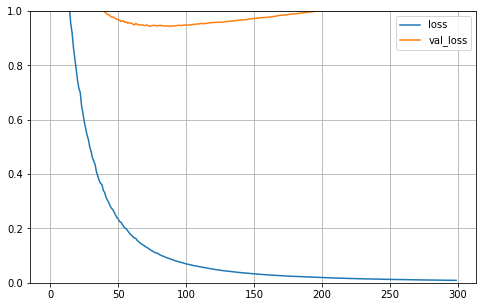

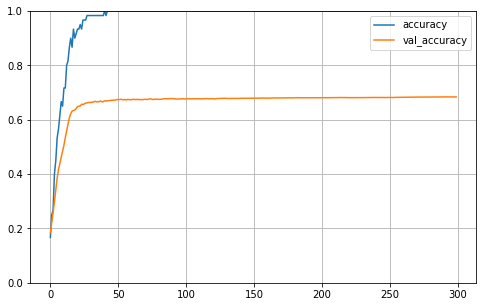

In [133]:
training_history_df = pd.DataFrame(training_history.history)

training_history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

training_history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

print(("Best Val Loss: {:0.4f}" +\
      "\nBest Val Accuracy: {:0.4f}")\
      .format(training_history_df['val_loss'].min(), 
              training_history_df['val_accuracy'].max()))

In [75]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 953us/step - loss: 1.1764 - accuracy: 0.6312


[1.1763544082641602, 0.6312000155448914]

In [51]:
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

Test Report
              precision    recall  f1-score   support

           0     0.8195    0.8670    0.8426      1000
           1     0.9831    0.9870    0.9850      1000
           2     0.8332    0.8340    0.8336      1000
           3     0.9129    0.9120    0.9125      1000
           4     0.8441    0.8500    0.8470      1000
           5     0.9794    0.9490    0.9639      1000
           6     0.7609    0.6970    0.7276      1000
           7     0.9262    0.9660    0.9457      1000
           8     0.9704    0.9820    0.9761      1000
           9     0.9617    0.9530    0.9573      1000

    accuracy                         0.8997     10000
   macro avg     0.8991    0.8997    0.8991     10000
weighted avg     0.8991    0.8997    0.8991     10000



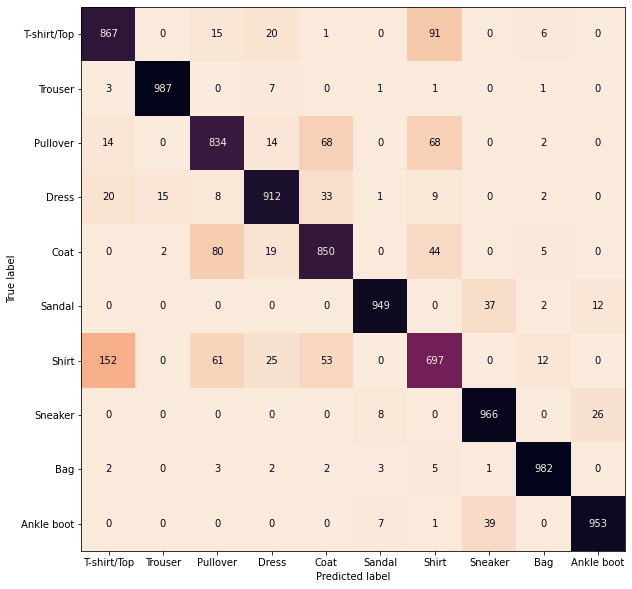

In [52]:
print('Test Report')
print(classification_report(y_test, y_test_pred, digits=4))

matrix = plot_confusion_matrix_by_predictions(y_test, y_test_pred, display_labels=label_names)
matrix.figure_.set_figheight(10)
matrix.figure_.set_figwidth(10)

In [ ]:
## Chance Model
# Loss: 2.43648624420166
# Accuracy: 0.12780000269412994

## Dense(300, activation='relu'), Dense(100, activation='relu'), SGD
# Best Val Loss: 0.3154
# Best Val Accuracy: 0.8987
# Best Test Loss: 0.3189171850681305
# Best Test Accuracy: 0.8956999778747559

## Dense(300, activation='relu'), Dense(100, activation='relu'), Adam(lr=0.0005)
# Best Val Loss: 0.3054
# Best Val Accuracy: 0.8972
# Best Test Loss: 0.31720462441444397
# Best Test Accuracy: 0.8913999795913696

## Dense(300, activation='relu'), BatchNorm(), Dense(100, activation='relu'), BatchNorm(), Adam(lr=0.0005)
# Best Val Loss: 0.3020
# Best Val Accuracy: 0.8958
# Best Test Loss: 0.33810487389564514
# Best Test Accuracy: 0.8925999999046326

## Adam(lr=0.0005), Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2882
# Best Val Accuracy: 0.8964
# Best Test Loss: 0.3012319505214691
# Best Test Accuracy: 0.8920000195503235

## Adam(lr=0.0005), batch_size=32, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2822
# Best Val Accuracy: 0.9010
# Best Test Loss: 0.29744410514831543
# Best Test Accuracy: 0.8920999765396118

## Adam(lr=0.0005), batch_size=64, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.3215
# Best Val Accuracy: 0.9032
# Best Test Loss: 0.29807841777801514
# Best Test Accuracy: 0.8945000171661377

## RMSprop(), batch_size=32, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.3024
# Best Val Accuracy: 0.8970
# Best Test Loss: 0.3157300651073456
# Best Test Accuracy: 0.8924000263214111

## RMSprop(), batch_size=256, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2886
# Best Val Accuracy: 0.9017
# Best Test Loss: 0.2969489097595215
# Best Test Accuracy: 0.8981000185012817

## Adam(lr=0.0005), batch_size=256, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2938
# Best Val Accuracy: 0.9023
# Best Test Loss: 0.29765433073043823
# Best Test Accuracy: 0.8996000289916992

## Nadam(lr=0.0005), batch_size=256, Dense(300, activation='selu'), AlphaDropout(0.2), Dense(100, activation='selu'), AlphaDropout(0.2), Dense(50, activation='selu'), AlphaDropout(0.2)
# Best Val Loss: 0.3629
# Best Val Accuracy: 0.9026
# Best Test Loss: 0.39967575669288635
# Best Test Accuracy: 0.8942999839782715

## Nadam(lr=0.001), batch_size=256, Dense(300, activation='selu', kernel_initializer='lecun_normal'), AlphaDropout(0.2), Dense(100, activation='selu', kernel_initializer='lecun_normal'), AlphaDropout(0.2), Dense(50, activation='selu', kernel_initializer='lecun_normal'), AlphaDropout(0.2)
# Best Val Loss: 0.4443
# Best Val Accuracy: 0.9081
# Best Test Loss: 0.5121541023254395
# Best Test Accuracy: 0.8996999859809875

## Error Analysis

In [29]:
missclass_label_indices = [
    idx for idx, (label_true, label_pred) in enumerate(zip(y_test, y_test_pred)) 
    if label_true == 6 and label_pred == 0
]

missclass_len = len(missclass_label_indices)

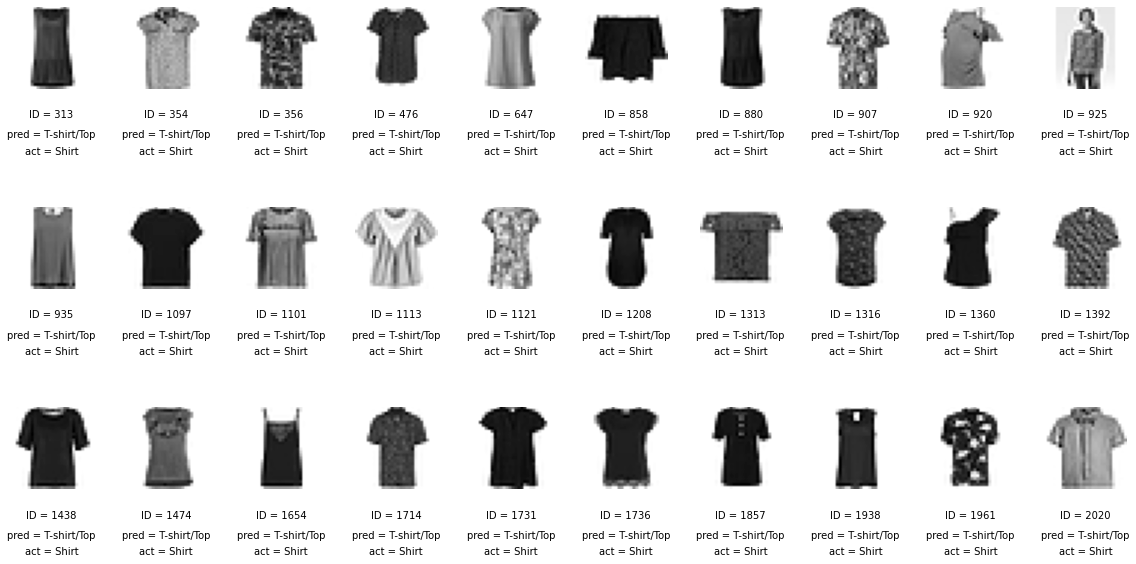

In [30]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(missclass_label_indices[:30]):    
    ax = fig.add_subplot(3, 10, i + 1)
    ax.axis('off')

    ax.text(0.5, -0.35, 'ID = ' + str(idx), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.6, 'pred = ' + label_names[y_test_pred[idx]], fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.8, 'act = ' + label_names[y_test[idx]], fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(np.reshape(X_test.values[idx], (28, 28)), cmap='binary')